# **Capítulo 10: Siguientes pasos**

## Reducción de dimensionalidad mediante t-SNE

Comprobación de acceso a GPU

In [2]:
import torch

# Si disponemos de GPU, la usamos
dispositivo = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Carga y preprocesado de datos

In [5]:
import torchvision.datasets as datasets
import torchvision.transforms as transforms

tam_batch = 64

# Datos de test:
test_dataset = datasets.MNIST(
    root='./datos', # Misma ruta que los datos de entrenamiento
    train=False,    # Datos de test
    transform=transforms.ToTensor(), # Conversión más normalización
    download=True   # Se descargan a la carpeta indicada en root
)
test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=tam_batch,
    shuffle=False   # Los datos se evalúan siempre en el mismo orden
)

100%|██████████| 9912422/9912422 [00:00<00:00, 26642574.74it/s]


Extracting ./datos/MNIST/raw/train-images-idx3-ubyte.gz to ./datos/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 57987407.29it/s]


Extracting ./datos/MNIST/raw/train-labels-idx1-ubyte.gz to ./datos/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 16078756.91it/s]


Extracting ./datos/MNIST/raw/t10k-images-idx3-ubyte.gz to ./datos/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 15770305.27it/s]

Extracting ./datos/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./datos/MNIST/raw



Implementación de la CNN a usar

In [6]:
import torch.nn as nn

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()

        # Capas:
        # 1) Bloque extractor de características
        self.conv1 = nn.Conv2d(1, 6, kernel_size=5, padding='same')
        self.pool1 = nn.MaxPool2d(kernel_size=2)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5, padding='same')
        self.pool2 = nn.MaxPool2d(kernel_size=2)
        # 2) Bloque clasificador de características
        self.flatten = nn.Flatten()
        self.lin1 = nn.Linear(16 * 7 * 7, 120)
        self.lin2 = nn.Linear(120, 84)
        self.lin3 = nn.Linear(84, 10)

        # Activaciones:
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.pool1(x)
        x = self.relu(self.conv2(x))
        x = self.pool2(x)
        x = self.flatten(x)
        x = self.relu(self.lin1(x))
        x = self.relu(self.lin2(x))
        y = self.lin3(x)
        return y

modelo = CNN().to(dispositivo)
# Cargamos los pesos del modelo
modelo.load_state_dict(torch.load('modelo_cap_5.pt'))

<All keys matched successfully>

Aplicamos t-SNE

In [28]:
import numpy as np
from sklearn.manifold import TSNE

# Obtenemos los embeddings del modelo y las etiquetas de los datos
embeddings = []
etiquetas = []
with torch.no_grad():
    for i, (x, y) in enumerate(test_loader):
        x = x.to(dispositivo)
        embeddings.append(modelo(x).squeeze().cpu().numpy())
        etiquetas.append(y)
embeddings = np.concatenate(embeddings)
etiquetas = np.concatenate(etiquetas)

# Aplicamos t-SNE
tsne = TSNE(n_components=2, random_state=42)
tsne_results = tsne.fit_transform(embeddings)

Visualizamos los resultados

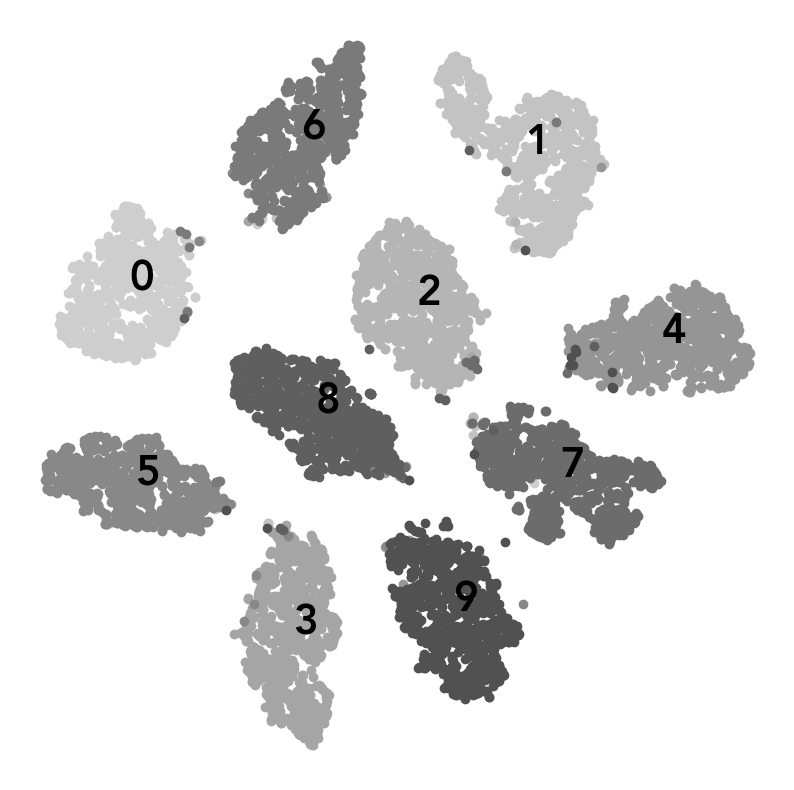

In [30]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm

plt.figure(figsize=(10, 10))

# Crear una paleta de colores en escala de grises
colors = cm.Greys(np.linspace(0.3, 1, 15))

for i in range(10):
    indices = etiquetas == i
    # Utilizar el color correspondiente de la paleta para cada scatter plot
    plt.scatter(tsne_results[indices, 0], tsne_results[indices, 1], color=colors[i], label=str(i))

    # Calculamos el centroide de cada cluster para poder situar en
    # esa posición la etiqueta correspondiente
    x_centroid = np.mean(tsne_results[indices, 0])
    y_centroid = np.mean(tsne_results[indices, 1])
    plt.text(x_centroid, y_centroid, str(i), fontsize=30, weight='bold')

plt.axis('off')
plt.show()